In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..', '..'))

In [2]:

sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

## Get physical constants from Scipy
import scipy.constants as con
## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
kb = con.physical_constants['Boltzmann constant in eV/K'][0]

import scipy.integrate as int

import scipy.io as sio

import scipy.optimize as opt

from misloc_package.parameterize import displaced_osc_model as dom


Plot parameters

In [3]:
## This needs to be in a seperate cell from the imports
## Matplotlib settings
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 300,  # to adjust notebook inline plot size
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': False,
#     'figure.figsize': [3.5, 2.625], # 4 x 3
#     'figure.figsize': [4, 3], # 4 x 3
    'figure.figsize': [4*1.125, 3*1.125], # 4x3, full slide in keynote
    'font.family': 'serif',
    'figure.max_open_warning':100
}
mpl.rcParams.update(params)


Load data 

In [4]:
path_to_mol_data = os.path.join('..', 'data')

emily_data = np.loadtxt(
    os.path.join(path_to_mol_data, 'avg-CH3.csv'), 
#     skiprows=0, 
    delimiter=','
    )

## Some useful functions
def norm_spec(spec):
    return spec/spec.max()

# def nm_to_ev_correct(spec):
#     return spec/(1240/thermo_fisher_dye_data.T[0])**5.

# Area Normalized with x-scale

In [5]:
def model_from_params(
    params, 
    num_modes, 
    temp
    ):
    return dom.anda_mol_fluo_model(
        num_vib_modes=num_modes,
        hbar_omega_eg_0=float(params[0]),
        script_d=params[2+1*num_modes: 2+2*num_modes],
        hbar_omega_0=params[2: 2+1*num_modes],
        hbar_gamma=[params[1]]*num_modes,
        T=temp)

def muk_mol_fit_fun(params, *args):
    """ Try naive fit function with fixed integration differential size
        and bound.

        Params: (list of fit parameters) Should be list of 
            2 + (3*num_modes) containing the following model parameters;
            ~~~~~~~~~~~~~~~~
            [0] hbar_omega_eg_0: the difference in zero point energy of 
                the vibrational oscillators between the two electronic
                states (eV).
                
            [1] hbar_gamma: damping rate from 
                solvent or etc.
            
            [2:2+num_modes] hbar_omega_0: vibrational ressonance energy 
                in eV.
                
            [2+num_modes:2+2*num_modes] script_d: unitless 
                displacement of the vibronic potential surface between
                electronic states.

        Args: (list of x axis and data)
        ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            hbar_omega:
            data:
            num_modes:
        """
    [
        hbar_omegas, 
        data, 
        num_modes, 
        t_bound, 
        t_points, 
        norm,
        temp
        ] = args

    model_instance = model_from_params(params, num_modes, temp=temp)
    
    model = model_instance.emission_lineshape(
        hbar_omegas/hbar,
        t_bound=t_bound,
        t_points=t_points,
        )

    if (norm is 'integral') or (norm is 'Integral') or (norm is 'int'):
        ## Normalize model and data
        model_area = int.trapz(model, x=hbar_omegas)
        model = model / model_area
    elif norm is 'magnitude':
        ## Normalize model and data
        model = model / np.max(model)
        data = data / np.max(data)

    return model - data

In [6]:
## Define initial guesses
ini_hbar_omega_eg_0 = 2.63
ini_script_d = [1.6, 1.3]
ini_hbar_omega_0 = [0.13, .02]
ini_hbar_gamma = .015
T = 292

## Bounds on fit parameters
bounds_hbar_omega_eg_0 = [2, 2.75]
bounds_script_d = [[0, 0], [np.inf, np.inf]]
bounds_hbar_omega_0 = [[0, 0], [np.inf, np.inf]]
bounds_hbar_gamma = [0.001, np.inf]


## New 06/02
## Sort initil guesses into proper order for fit func
fit_ini_guess = np.asarray([
    ini_hbar_omega_eg_0,
    ini_hbar_gamma,
    *ini_hbar_omega_0,
    *ini_script_d,
    ])
## Define arguments for fit routine
## (Might have to change these)

hbar_omegas_arg = emily_data.T[0]
data_arg = emily_data.T[1]
num_modes_arg = 2
t_bound_arg = 1000
t_points_arg = 1000
norm_arg = 'integral'

## Arrange fit arguments
## (Don't change)
fit_args = (
    hbar_omegas_arg,
    data_arg,
    num_modes_arg,
    t_bound_arg,
    t_points_arg,
    norm_arg,
    T
    )

## Build bounds arrays
bounds = np.zeros((2, fit_ini_guess.shape[0]))
bounds[:, 0] = bounds_hbar_omega_eg_0
bounds[:, 1] = bounds_hbar_gamma
bounds[:, 2:2+num_modes_arg] = bounds_hbar_omega_0
bounds[:, 2+num_modes_arg:2+2*num_modes_arg] = bounds_script_d

model_fit = opt.least_squares(
    muk_mol_fit_fun,
    x0=fit_ini_guess,
    args=fit_args,
    bounds=bounds,
    x_scale=[1, .01, .1, .01, 1, 1]
    )

Plot fit result

Text(0, 0.5, 'Normalized Emission Probability')

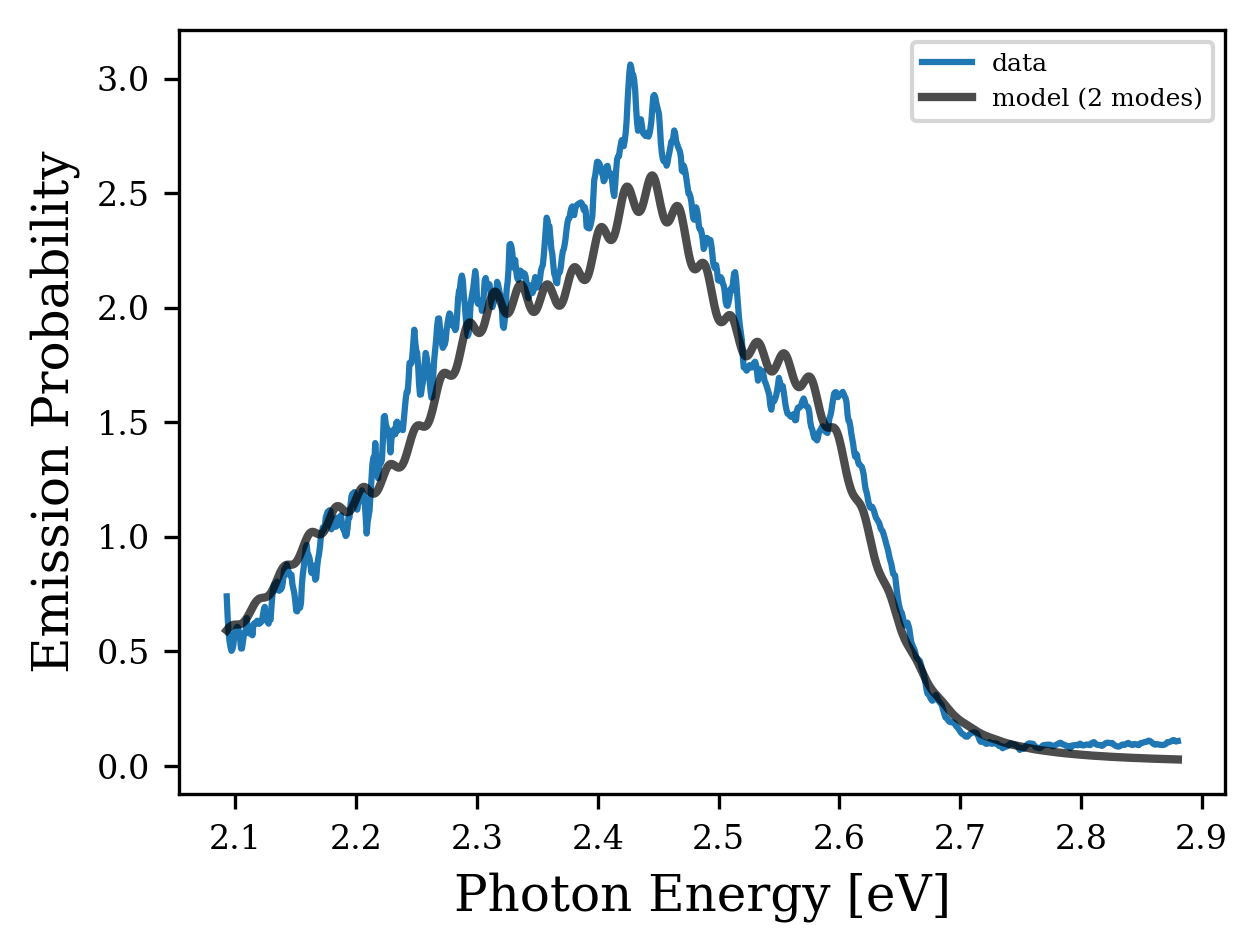

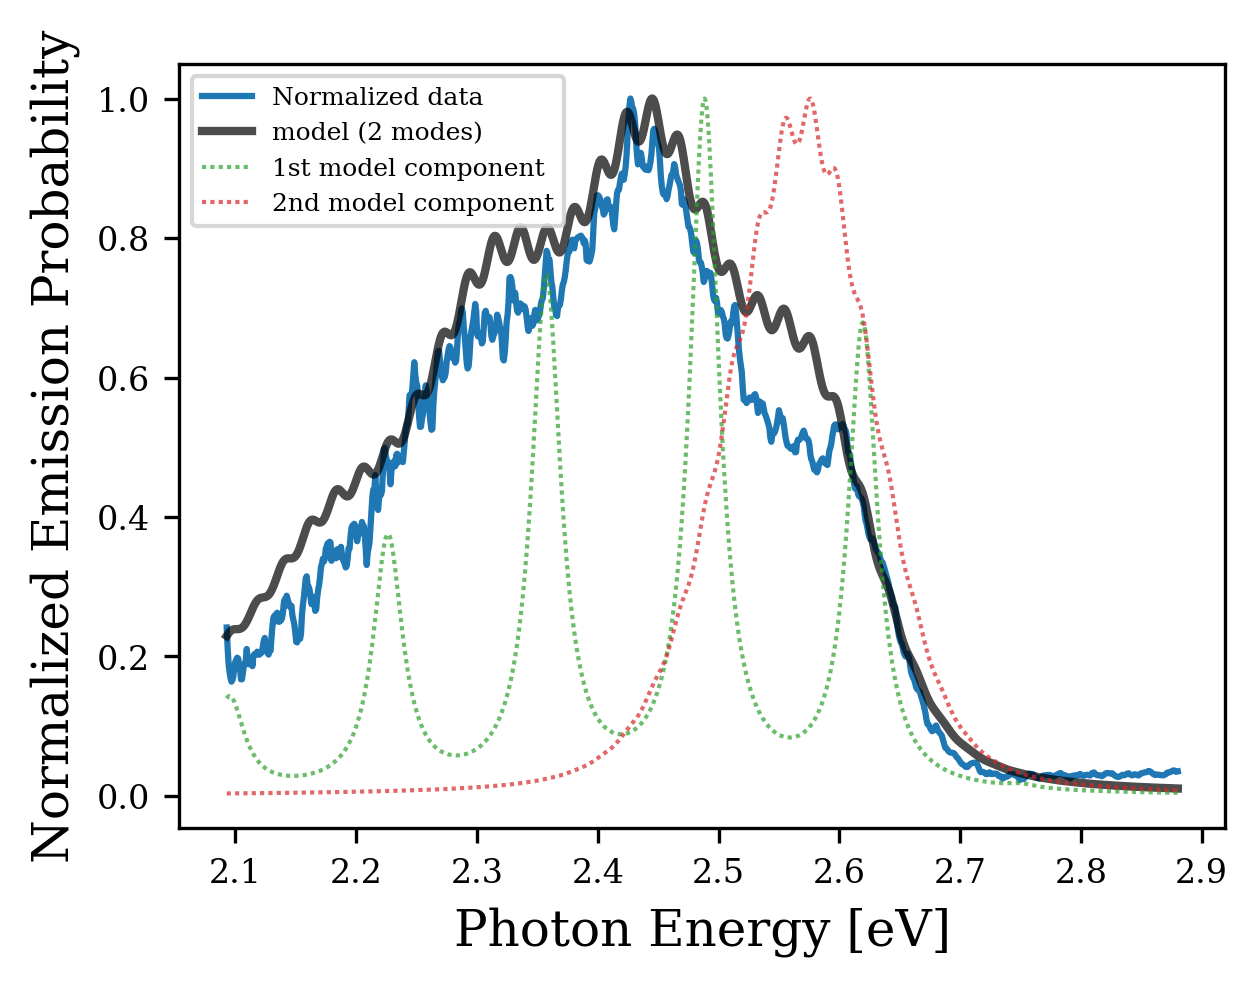

In [7]:
## Build model fit from fit parameters
model_fit_inst = model_from_params(model_fit['x'], num_modes=2, temp=T)

## Get model lineshape
model_2_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 1000)

##
model_1st_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 1000)

model_2nd_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 1000)


## Build first plot
plt.figure()

## Plot data and model fit
plt.plot(emily_data.T[0], (emily_data.T[1]), label='data')
plt.plot(emily_data.T[0], (model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')

plt.legend(fontsize=6)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Emission Probability')

## second figure with components
plt.figure()
plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]), label='Normalized data')
plt.plot(emily_data.T[0], norm_spec(model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.7, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.7, label='2nd model component')

plt.legend(fontsize=6)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')


In [8]:
def print_parameters_w_names(params):
    """Only works for 2 modes"""
    print(f'hbar_omega_eg_0 = {params[0]}')
    print(f'hbar_gamma = {params[1]}')
    print(f'hbar_omega_0 = {params[2:4]}')
    print(f'script_d = {params[4:6]}')

In [9]:
print_parameters_w_names(model_fit['x'])

hbar_omega_eg_0 = 2.619502841178455
hbar_gamma = 0.014806470719337316
hbar_omega_0 = [0.1310697  0.02157974]
script_d = [1.71986998 2.22477128]


In [10]:
fit_spectra = np.asarray([ emily_data.T[0], emily_data.T[1], model_2_mode])
np.savetxt("fast_CH3_fit", fit_spectra, delimiter=',')

New intial guesses

In [11]:
## Define initial guesses
ini_hbar_omega_eg_0 = 2.62
ini_script_d = [1.7, 2]
ini_hbar_omega_0 = [0.13, .02]
ini_hbar_gamma = .015
T = 292

## Bounds on fit parameters
bounds_hbar_omega_eg_0 = [2, 2.75]
bounds_script_d = [[0, 0], [np.inf, np.inf]]
bounds_hbar_omega_0 = [[0, 0], [np.inf, np.inf]]
bounds_hbar_gamma = [0.001, np.inf]


## New 06/02
## Sort initil guesses into proper order for fit func
fit_ini_guess = np.asarray([
    ini_hbar_omega_eg_0,
    ini_hbar_gamma,
    *ini_hbar_omega_0,
    *ini_script_d,
    ])
## Define arguments for fit routine
## (Might have to change these)

hbar_omegas_arg = emily_data.T[0]
data_arg = emily_data.T[1]
num_modes_arg = 2
t_bound_arg = 1000
t_points_arg = 1000
norm_arg = 'integral'

## Arrange fit arguments
## (Don't change)
fit_args = (
    hbar_omegas_arg,
    data_arg,
    num_modes_arg,
    t_bound_arg,
    t_points_arg,
    norm_arg,
    T
    )

## Build bounds arrays
bounds = np.zeros((2, fit_ini_guess.shape[0]))
bounds[:, 0] = bounds_hbar_omega_eg_0
bounds[:, 1] = bounds_hbar_gamma
bounds[:, 2:2+num_modes_arg] = bounds_hbar_omega_0
bounds[:, 2+num_modes_arg:2+2*num_modes_arg] = bounds_script_d

model_fit = opt.least_squares(
    muk_mol_fit_fun,
    x0=fit_ini_guess,
    args=fit_args,
    bounds=bounds,
    x_scale=[1, .01, .1, .01, 1, 1]
    )

Plot fit result

Text(0, 0.5, 'Normalized Emission Probability')

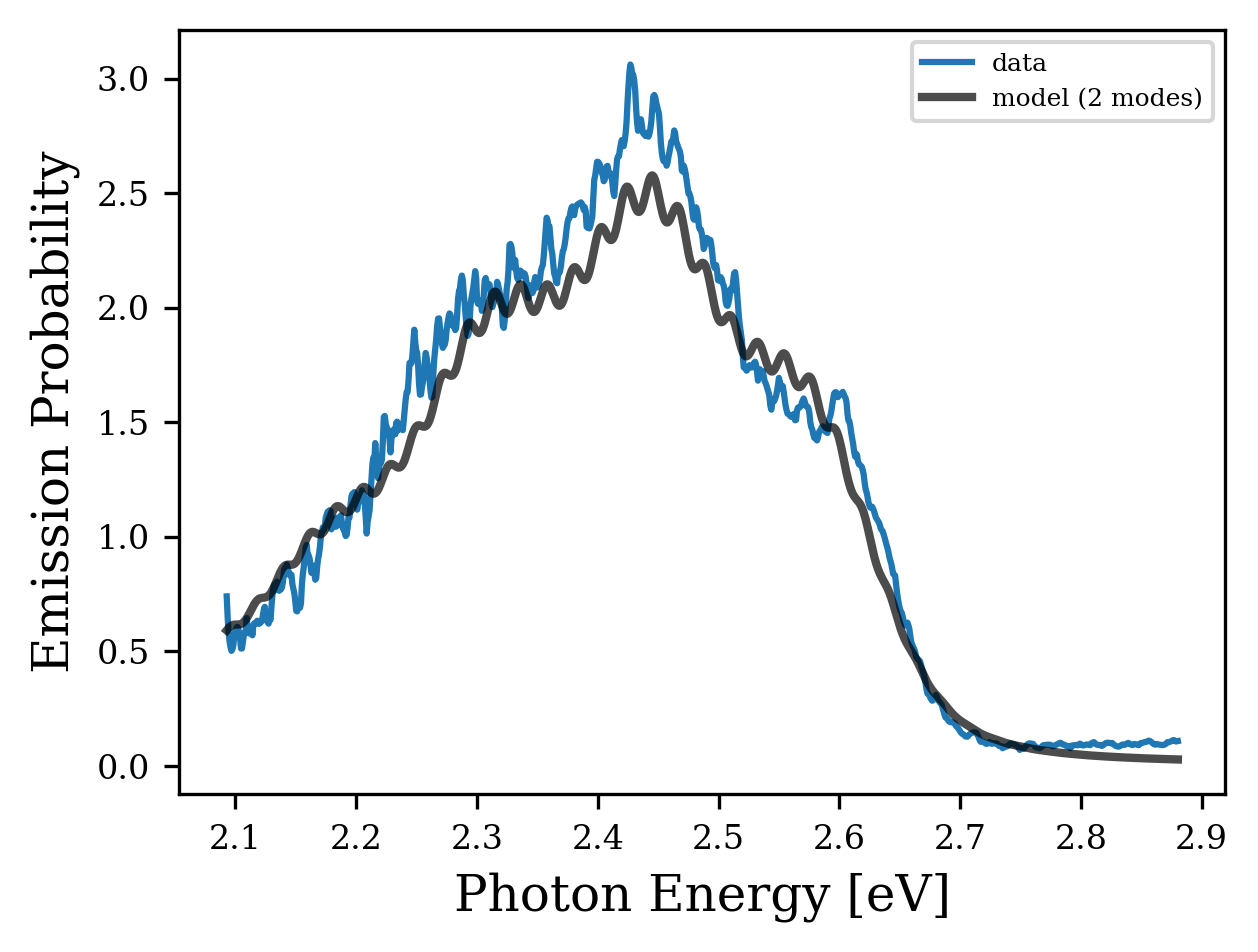

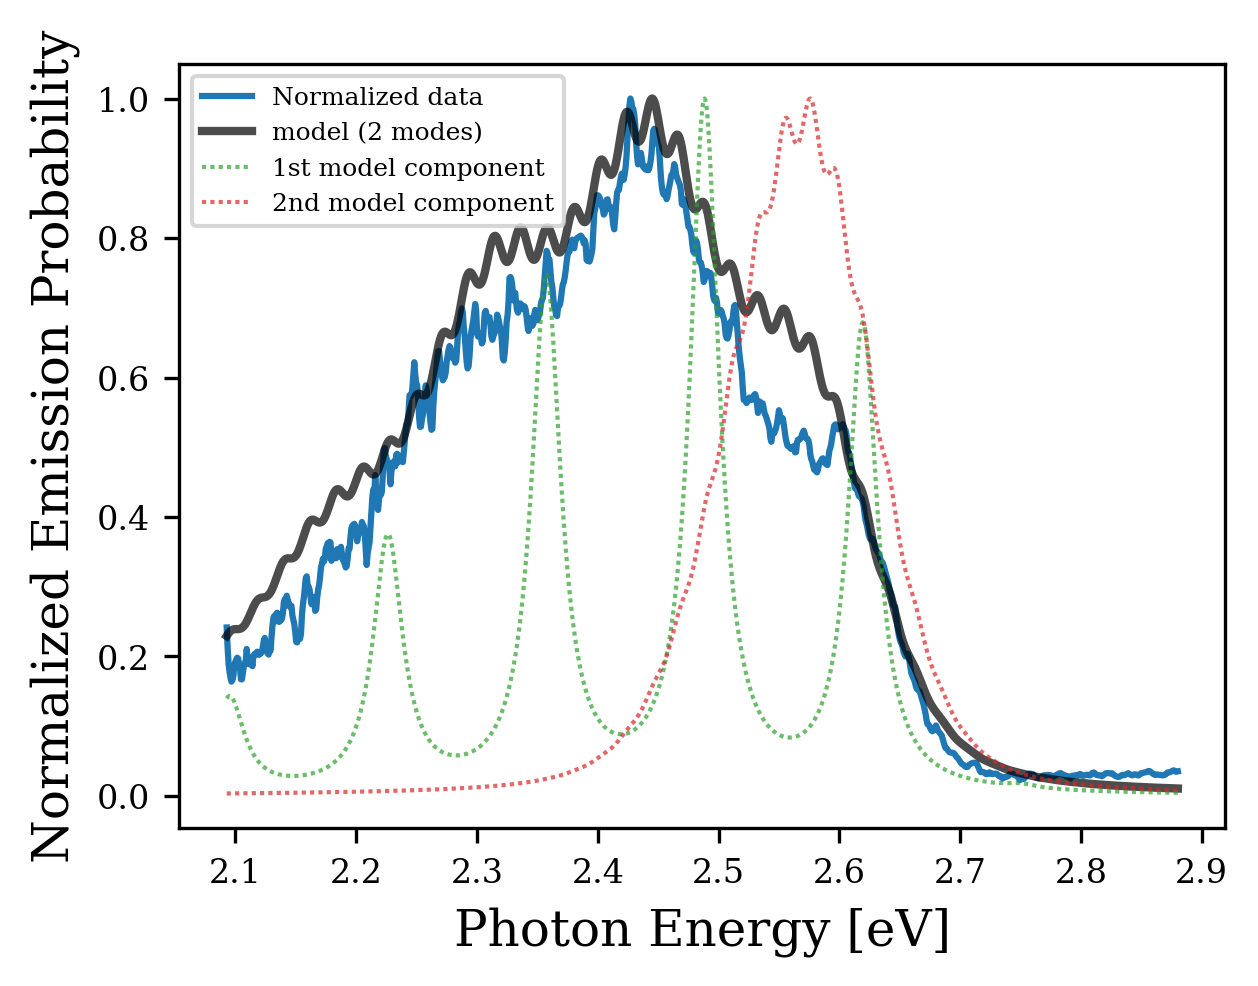

In [12]:
## Build model fit from fit parameters
model_fit_inst = model_from_params(model_fit['x'], num_modes=2, temp=T)

## Get model lineshape
model_2_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 1000)

##
model_1st_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 1000)

model_2nd_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 1000)


## Build first plot
plt.figure()

## Plot data and model fit
plt.plot(emily_data.T[0], (emily_data.T[1]), label='data')
plt.plot(emily_data.T[0], (model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')

plt.legend(fontsize=6)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Emission Probability')

## second figure with components
plt.figure()
plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]), label='Normalized data')
plt.plot(emily_data.T[0], norm_spec(model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.7, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.7, label='2nd model component')

plt.legend(fontsize=6)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')


In [13]:
def print_parameters_w_names(params):
    """Only works for 2 modes"""
    print(f'hbar_omega_eg_0 = {params[0]}')
    print(f'hbar_gamma = {params[1]}')
    print(f'hbar_omega_0 = {params[2:4]}')
    print(f'script_d = {params[4:6]}')

In [14]:
print_parameters_w_names(model_fit['x'])

hbar_omega_eg_0 = 2.619502790465527
hbar_gamma = 0.014806301000461283
hbar_omega_0 = [0.13107008 0.02157951]
script_d = [1.71986872 2.22478055]


In [15]:
fit_spectra = np.asarray([ emily_data.T[0], emily_data.T[1], model_2_mode])
np.savetxt("fast_CH3_fit", fit_spectra, delimiter=',')

New intial guesses

In [16]:
## Define initial guesses
ini_hbar_omega_eg_0 = 2.62
ini_script_d = [1.73, 2]
ini_hbar_omega_0 = [0.132, .02]
ini_hbar_gamma = .015
T = 292

## Bounds on fit parameters
bounds_hbar_omega_eg_0 = [2, 2.75]
bounds_script_d = [[0, 0], [np.inf, np.inf]]
bounds_hbar_omega_0 = [[0, 0], [np.inf, np.inf]]
bounds_hbar_gamma = [0.001, np.inf]


## New 06/02
## Sort initil guesses into proper order for fit func
fit_ini_guess = np.asarray([
    ini_hbar_omega_eg_0,
    ini_hbar_gamma,
    *ini_hbar_omega_0,
    *ini_script_d,
    ])
## Define arguments for fit routine
## (Might have to change these)

hbar_omegas_arg = emily_data.T[0]
data_arg = emily_data.T[1]
num_modes_arg = 2
t_bound_arg = 1000
t_points_arg = 1000
norm_arg = 'integral'

## Arrange fit arguments
## (Don't change)
fit_args = (
    hbar_omegas_arg,
    data_arg,
    num_modes_arg,
    t_bound_arg,
    t_points_arg,
    norm_arg,
    T
    )

## Build bounds arrays
bounds = np.zeros((2, fit_ini_guess.shape[0]))
bounds[:, 0] = bounds_hbar_omega_eg_0
bounds[:, 1] = bounds_hbar_gamma
bounds[:, 2:2+num_modes_arg] = bounds_hbar_omega_0
bounds[:, 2+num_modes_arg:2+2*num_modes_arg] = bounds_script_d

model_fit = opt.least_squares(
    muk_mol_fit_fun,
    x0=fit_ini_guess,
    args=fit_args,
    bounds=bounds,
    x_scale=[1, .01, .1, .01, 1, 1]
    )

Plot fit result

Text(0, 0.5, 'Normalized Emission Probability')

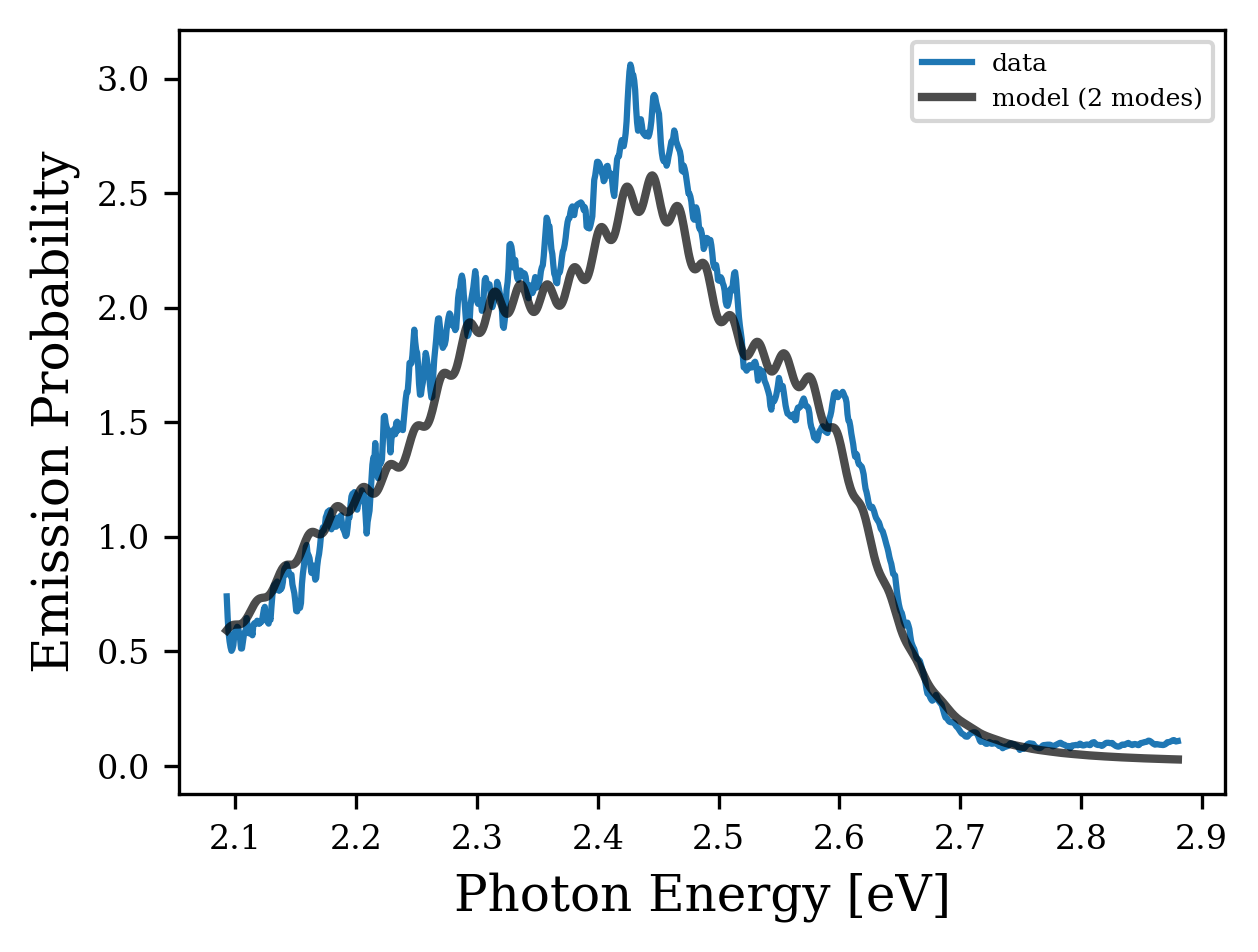

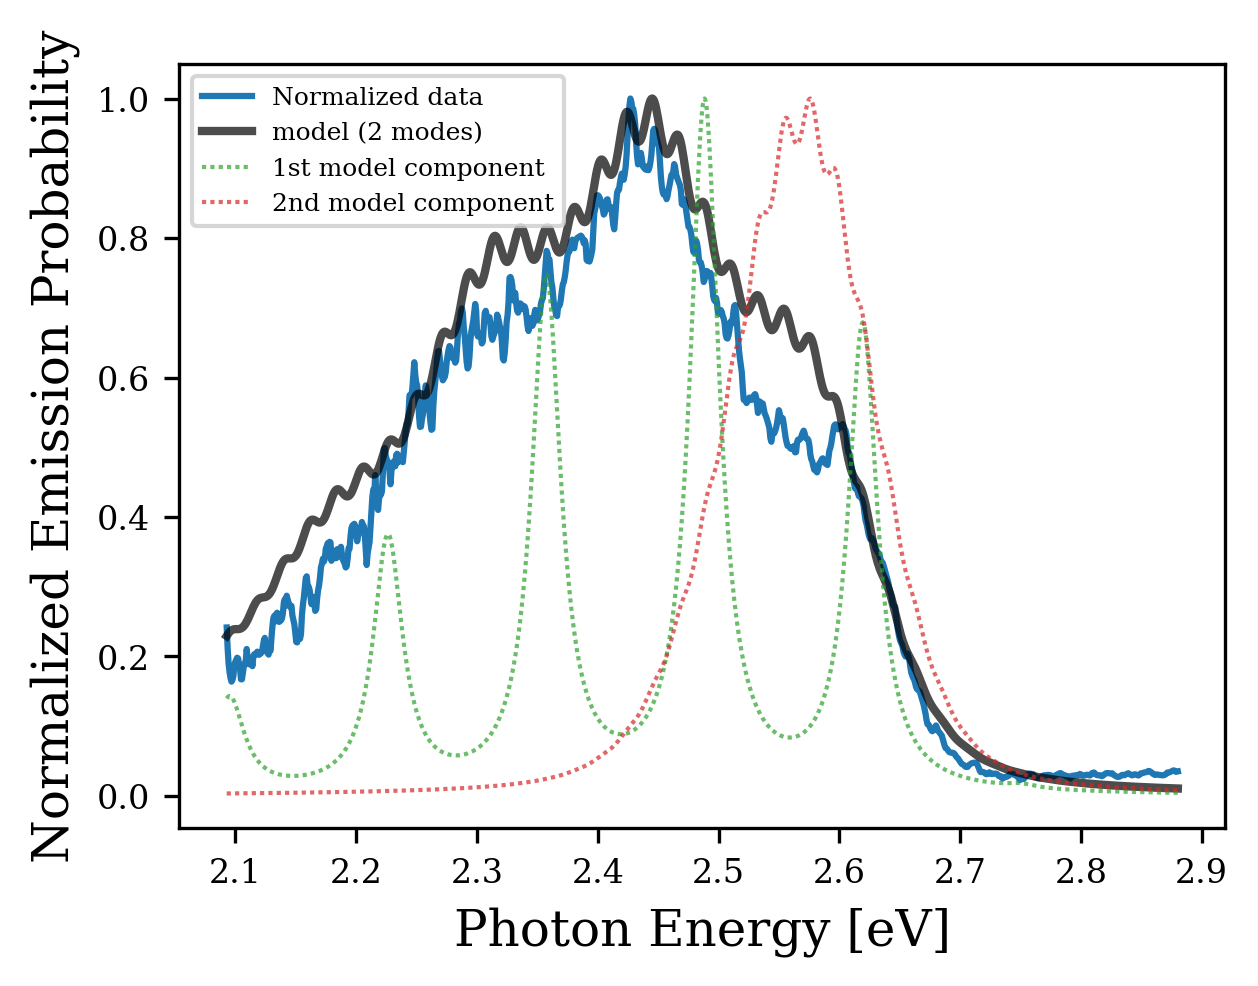

In [17]:
## Build model fit from fit parameters
model_fit_inst = model_from_params(model_fit['x'], num_modes=2, temp=T)

## Get model lineshape
model_2_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 1000)

##
model_1st_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 1000)

model_2nd_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 1000)


## Build first plot
plt.figure()

## Plot data and model fit
plt.plot(emily_data.T[0], (emily_data.T[1]), label='data')
plt.plot(emily_data.T[0], (model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')

plt.legend(fontsize=6)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Emission Probability')

## second figure with components
plt.figure()
plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]), label='Normalized data')
plt.plot(emily_data.T[0], norm_spec(model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.7, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.7, label='2nd model component')

plt.legend(fontsize=6)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')


In [18]:
def print_parameters_w_names(params):
    """Only works for 2 modes"""
    print(f'hbar_omega_eg_0 = {params[0]}')
    print(f'hbar_gamma = {params[1]}')
    print(f'hbar_omega_0 = {params[2:4]}')
    print(f'script_d = {params[4:6]}')

In [19]:
print_parameters_w_names(model_fit['x'])

hbar_omega_eg_0 = 2.6195028259570594
hbar_gamma = 0.014806420207012495
hbar_omega_0 = [0.13106981 0.02157967]
script_d = [1.7198696  2.22477404]


In [20]:
fit_spectra = np.asarray([ emily_data.T[0], emily_data.T[1], model_2_mode])
np.savetxt("fast_CH3_fit", fit_spectra, delimiter=',')

In [22]:
#residual sum of squares
ss_res= np.sum((emily_data.T[1]- model_2_mode)**2)

#total sum of squares
ss_tot = np.sum((emily_data.T[1]- np.mean(emily_data.T[1]))**2)

#r-squared
r2 = 1- (ss_res/ss_tot)

print(ss_res, r2)

26.435211965786056 0.9677099999318624


In [33]:
## Define initial guesses
ini_hbar_omega_eg_0 = 2.62
ini_script_d = [1.75, 2]
ini_hbar_omega_0 = [0.133, .02]
ini_hbar_gamma = .015
T = 292

## Bounds on fit parameters
bounds_hbar_omega_eg_0 = [2, 2.75]
bounds_script_d = [[0, 0], [np.inf, np.inf]]
bounds_hbar_omega_0 = [[0, 0], [np.inf, np.inf]]
bounds_hbar_gamma = [0.001, np.inf]


## New 06/02
## Sort initil guesses into proper order for fit func
fit_ini_guess = np.asarray([
    ini_hbar_omega_eg_0,
    ini_hbar_gamma,
    *ini_hbar_omega_0,
    *ini_script_d,
    ])
## Define arguments for fit routine
## (Might have to change these)

hbar_omegas_arg = emily_data.T[0]
data_arg = emily_data.T[1]
num_modes_arg = 2
t_bound_arg = 1000
t_points_arg = 1000
norm_arg = 'integral'

## Arrange fit arguments
## (Don't change)
fit_args = (
    hbar_omegas_arg,
    data_arg,
    num_modes_arg,
    t_bound_arg,
    t_points_arg,
    norm_arg,
    T
    )

## Build bounds arrays
bounds = np.zeros((2, fit_ini_guess.shape[0]))
bounds[:, 0] = bounds_hbar_omega_eg_0
bounds[:, 1] = bounds_hbar_gamma
bounds[:, 2:2+num_modes_arg] = bounds_hbar_omega_0
bounds[:, 2+num_modes_arg:2+2*num_modes_arg] = bounds_script_d

model_fit = opt.least_squares(
    muk_mol_fit_fun,
    x0=fit_ini_guess,
    args=fit_args,
    bounds=bounds,
    x_scale=[1, .01, .1, .01, 1, 1]
    )

Plot fit result

In [40]:
def int_norm(y, x=emily_data.T[0]):
    return y / int.trapz(y, x)

Text(0, 0.5, 'Normalized Emission Probability')

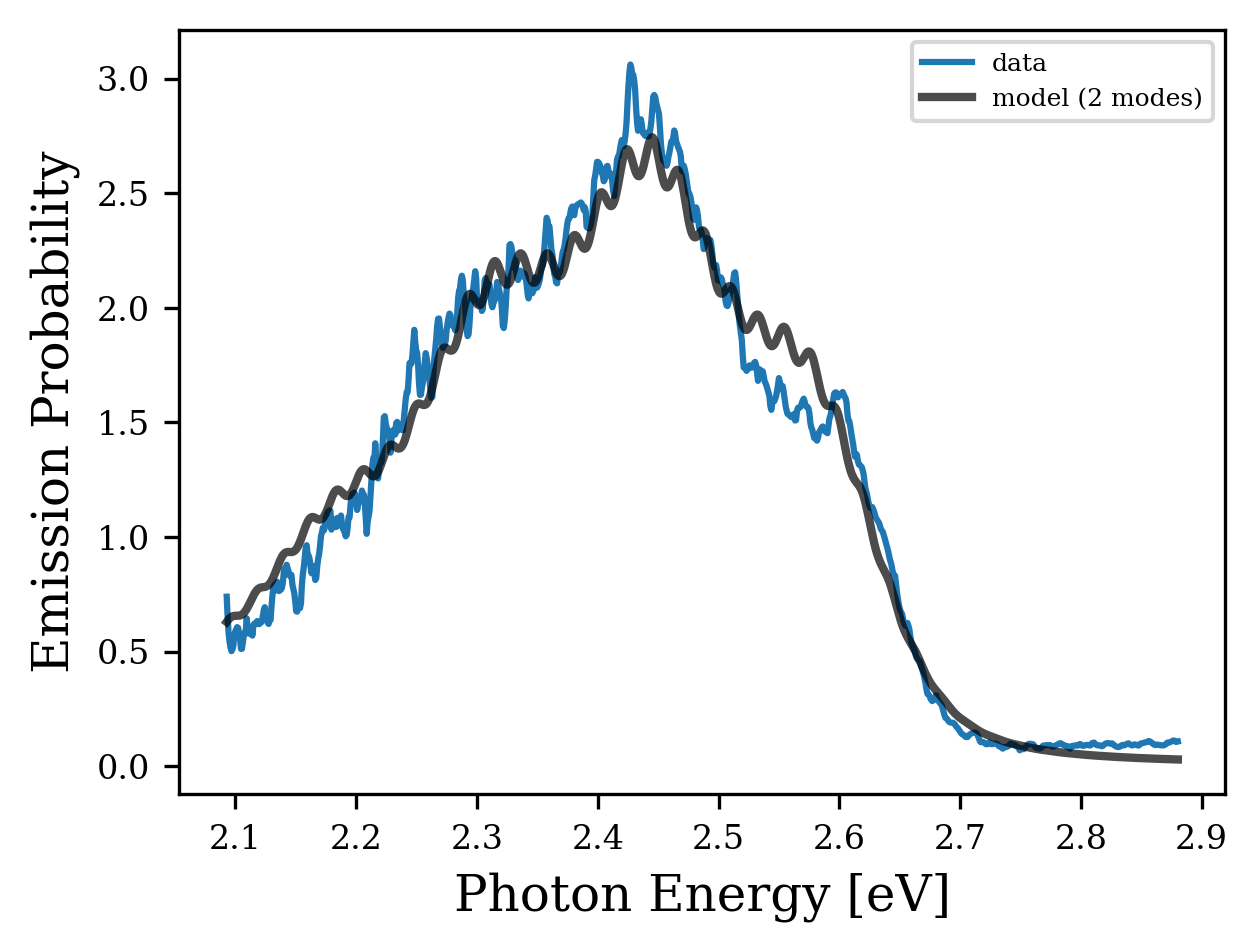

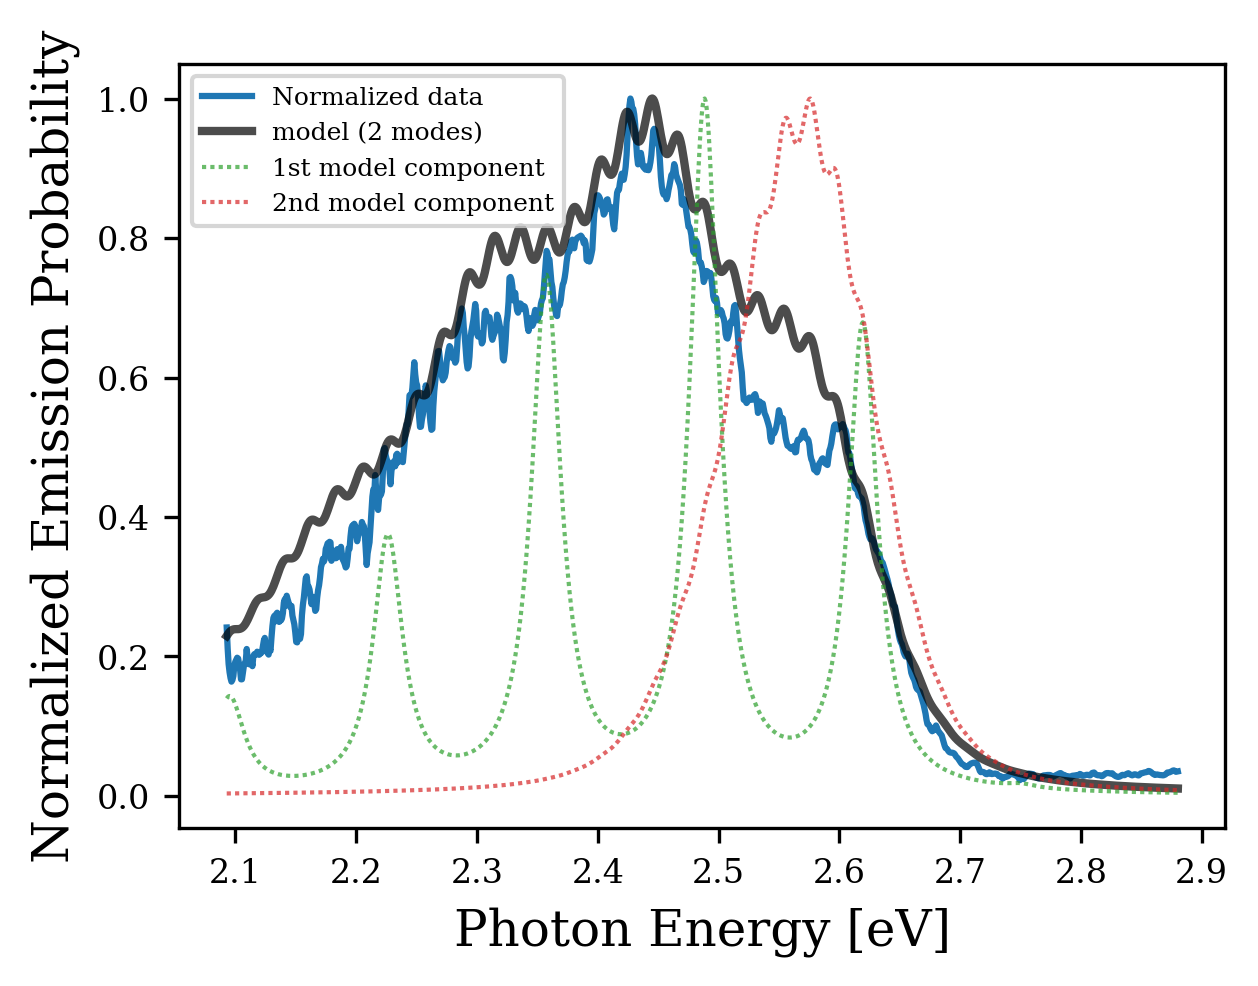

In [41]:
## Build model fit from fit parameters
model_fit_inst = model_from_params(model_fit['x'], num_modes=2, temp=T)

## Get model lineshape
model_2_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 1000)

##
model_1st_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 1000)

model_2nd_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 1000)


## Build first plot
plt.figure()

## Plot data and model fit
plt.plot(emily_data.T[0], (emily_data.T[1]), label='data')
plt.plot(emily_data.T[0], int_norm(model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')

plt.legend(fontsize=6)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Emission Probability')

## second figure with components
plt.figure()
plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]), label='Normalized data')
plt.plot(emily_data.T[0], norm_spec(model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.7, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.7, label='2nd model component')

plt.legend(fontsize=6)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')


In [39]:
print(int.trapz(emily_data.T[1], emily_data.T[0]))
print(int.trapz(model_2_mode, emily_data.T[0]))

1.00000113465
0.9392820109279884


In [35]:
def print_parameters_w_names(params):
    """Only works for 2 modes"""
    print(f'hbar_omega_eg_0 = {params[0]}')
    print(f'hbar_gamma = {params[1]}')
    print(f'hbar_omega_0 = {params[2:4]}')
    print(f'script_d = {params[4:6]}')

In [36]:
print_parameters_w_names(model_fit['x'])

hbar_omega_eg_0 = 2.619502376308952
hbar_gamma = 0.01480492473422029
hbar_omega_0 = [0.13107316 0.02157767]
script_d = [1.71985852 2.22485568]


In [20]:
fit_spectra = np.asarray([ emily_data.T[0], emily_data.T[1], model_2_mode])
np.savetxt("fast_CH3_fit", fit_spectra, delimiter=',')

In [37]:
#residual sum of squares
ss_res= np.sum((emily_data.T[1]- model_2_mode)**2)

#total sum of squares
ss_tot = np.sum((emily_data.T[1]- np.mean(emily_data.T[1]))**2)

#r-squared
r2 = 1- (ss_res/ss_tot)

print(ss_res, r2)

26.435443093709395 0.9677097176144491


# Raw averaged data


In [42]:
path_to_mol_data = os.path.join('..', 'data')

emily_data = np.loadtxt(
    os.path.join(path_to_mol_data, 'avg_raw_CH3.csv'), 
#     skiprows=0, 
    delimiter=','
    )

## Some useful functions
def norm_spec(spec):
    return spec/spec.max()

# def nm_to_ev_correct(spec):
#     return spec/(1240/thermo_fisher_dye_data.T[0])**5.

In [43]:
def model_from_params(
    params, 
    num_modes, 
    temp
    ):
    return dom.anda_mol_fluo_model(
        num_vib_modes=num_modes,
        hbar_omega_eg_0=float(params[0]),
        script_d=params[2+1*num_modes: 2+2*num_modes],
        hbar_omega_0=params[2: 2+1*num_modes],
        hbar_gamma=[params[1]]*num_modes,
        T=temp)

def muk_mol_fit_fun(params, *args):
    """ Try naive fit function with fixed integration differential size
        and bound.

        Params: (list of fit parameters) Should be list of 
            2 + (3*num_modes) containing the following model parameters;
            ~~~~~~~~~~~~~~~~
            [0] hbar_omega_eg_0: the difference in zero point energy of 
                the vibrational oscillators between the two electronic
                states (eV).
                
            [1] hbar_gamma: damping rate from 
                solvent or etc.
            
            [2:2+num_modes] hbar_omega_0: vibrational ressonance energy 
                in eV.
                
            [2+num_modes:2+2*num_modes] script_d: unitless 
                displacement of the vibronic potential surface between
                electronic states.

        Args: (list of x axis and data)
        ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            hbar_omega:
            data:
            num_modes:
        """
    [
        hbar_omegas, 
        data, 
        num_modes, 
        t_bound, 
        t_points, 
        norm,
        temp
        ] = args

    model_instance = model_from_params(params, num_modes, temp=temp)
    
    model = model_instance.emission_lineshape(
        hbar_omegas/hbar,
        t_bound=t_bound,
        t_points=t_points,
        )

    if (norm is 'integral') or (norm is 'Integral') or (norm is 'int'):
        ## Normalize model and data
        model_area = int.trapz(model, x=hbar_omegas)
        model = model / model_area
    elif norm is 'magnitude':
        ## Normalize model and data
        model = model / np.max(model)
        data = data / np.max(data)

    return model - data

In [44]:
## Define initial guesses
ini_hbar_omega_eg_0 = 2.62
ini_script_d = [1.75, 2]
ini_hbar_omega_0 = [0.133, .02]
ini_hbar_gamma = .015
T = 292

## Bounds on fit parameters
bounds_hbar_omega_eg_0 = [2, 2.75]
bounds_script_d = [[0, 0], [np.inf, np.inf]]
bounds_hbar_omega_0 = [[0, 0], [np.inf, np.inf]]
bounds_hbar_gamma = [0.001, np.inf]


## New 06/02
## Sort initil guesses into proper order for fit func
fit_ini_guess = np.asarray([
    ini_hbar_omega_eg_0,
    ini_hbar_gamma,
    *ini_hbar_omega_0,
    *ini_script_d,
    ])
## Define arguments for fit routine
## (Might have to change these)

hbar_omegas_arg = emily_data.T[0]
data_arg = emily_data.T[1]
num_modes_arg = 2
t_bound_arg = 1000
t_points_arg = 1000
norm_arg = 'integral'

## Arrange fit arguments
## (Don't change)
fit_args = (
    hbar_omegas_arg,
    data_arg,
    num_modes_arg,
    t_bound_arg,
    t_points_arg,
    norm_arg,
    T
    )

## Build bounds arrays
bounds = np.zeros((2, fit_ini_guess.shape[0]))
bounds[:, 0] = bounds_hbar_omega_eg_0
bounds[:, 1] = bounds_hbar_gamma
bounds[:, 2:2+num_modes_arg] = bounds_hbar_omega_0
bounds[:, 2+num_modes_arg:2+2*num_modes_arg] = bounds_script_d

model_fit = opt.least_squares(
    muk_mol_fit_fun,
    x0=fit_ini_guess,
    args=fit_args,
    bounds=bounds,
    x_scale=[1, .01, .1, .01, 1, 1]
    )

Plot fit result

In [45]:
def int_norm(y, x=emily_data.T[0]):
    return y / int.trapz(y, x)

Text(0, 0.5, 'Normalized Emission Probability')

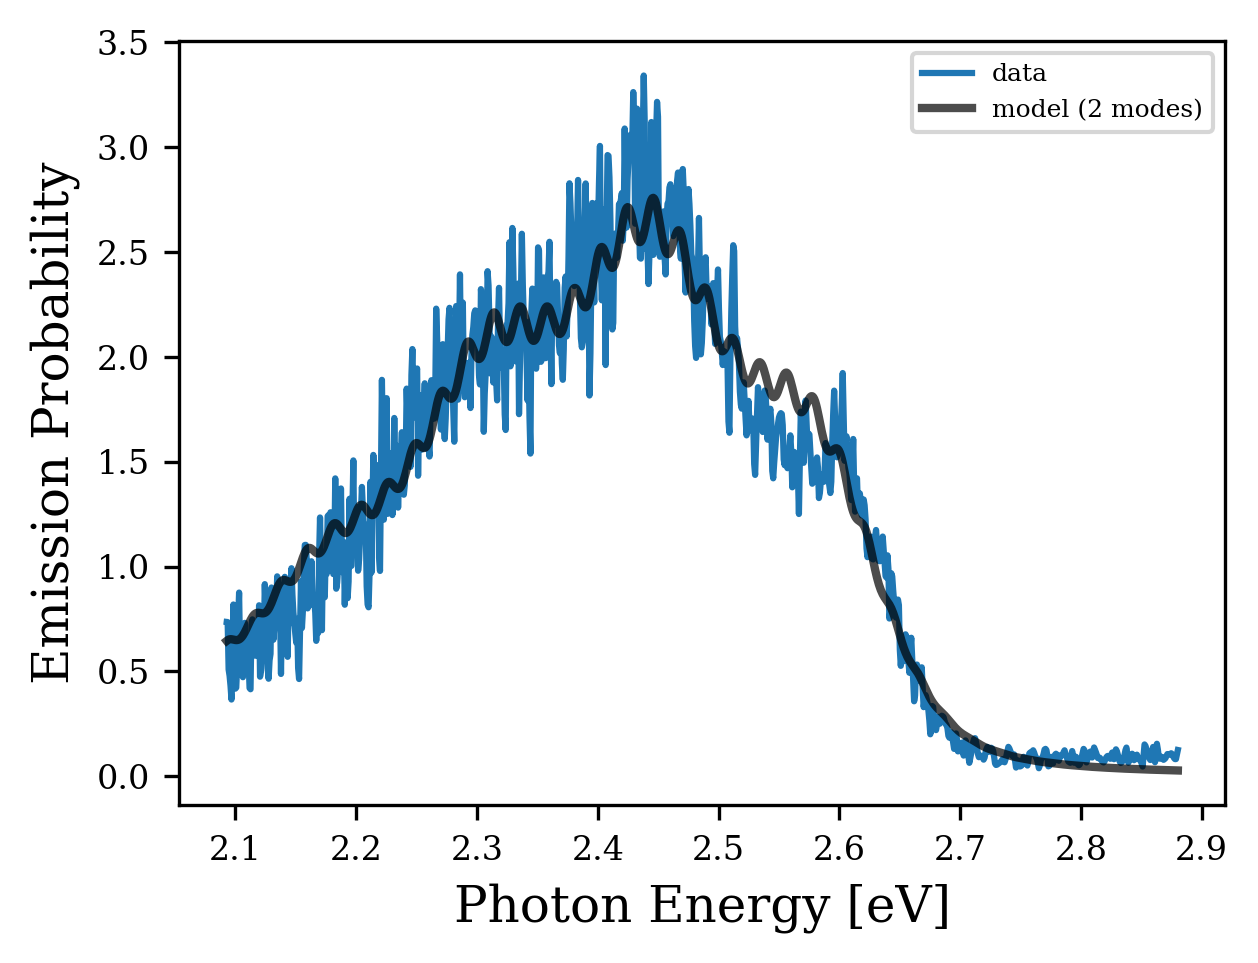

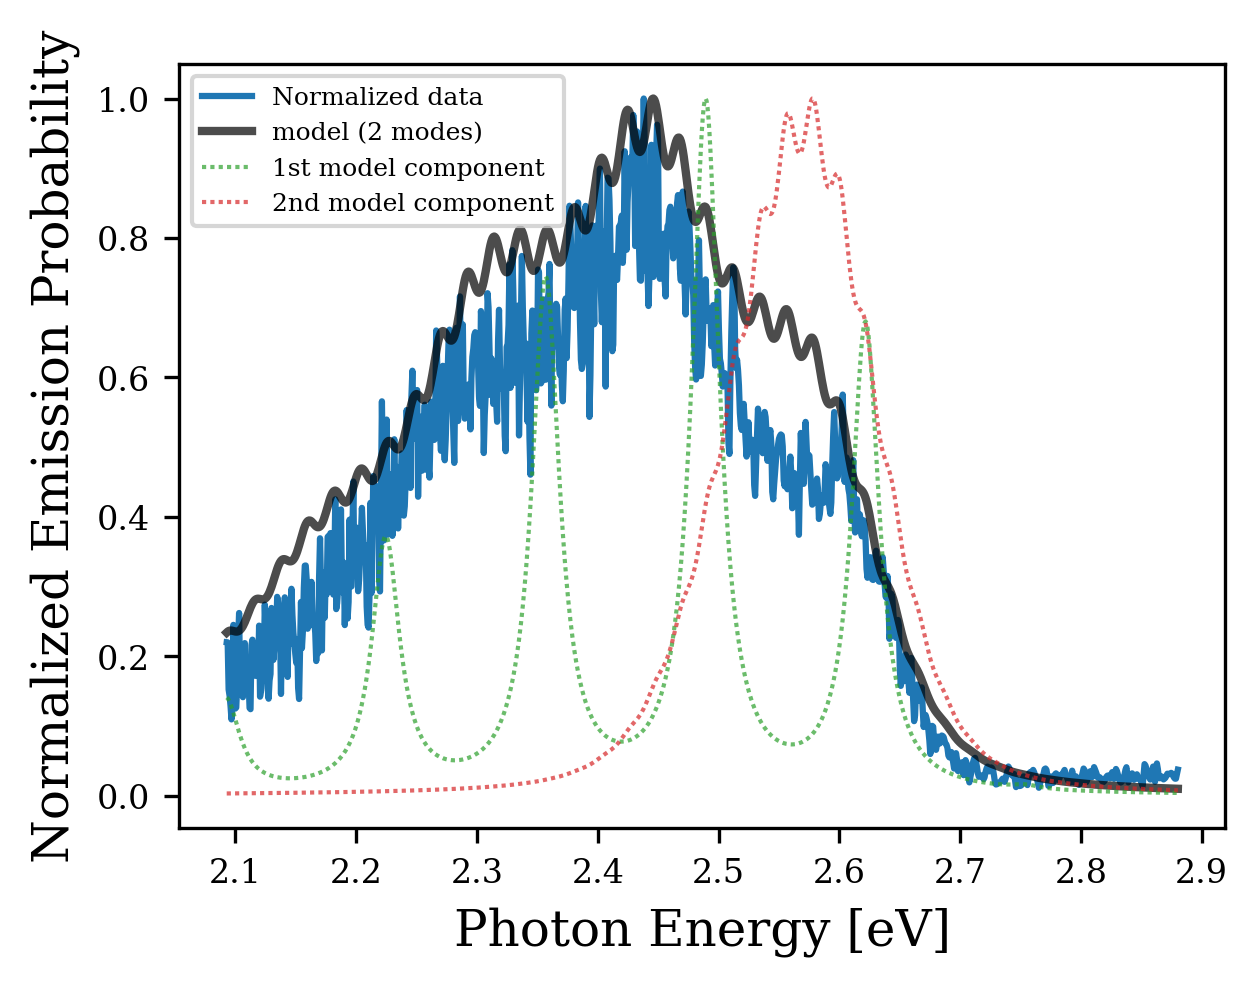

In [46]:
## Build model fit from fit parameters
model_fit_inst = model_from_params(model_fit['x'], num_modes=2, temp=T)

## Get model lineshape
model_2_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 1000)

##
model_1st_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 1000)

model_2nd_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 1000)


## Build first plot
plt.figure()

## Plot data and model fit
plt.plot(emily_data.T[0], (emily_data.T[1]), label='data')
plt.plot(emily_data.T[0], int_norm(model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')

plt.legend(fontsize=6)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Emission Probability')

## second figure with components
plt.figure()
plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]), label='Normalized data')
plt.plot(emily_data.T[0], norm_spec(model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.7, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.7, label='2nd model component')

plt.legend(fontsize=6)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')


In [47]:
print(int.trapz(emily_data.T[1], emily_data.T[0]))
print(int.trapz(model_2_mode, emily_data.T[0]))

0.9948184529000004
0.93910853168513


In [48]:
def print_parameters_w_names(params):
    """Only works for 2 modes"""
    print(f'hbar_omega_eg_0 = {params[0]}')
    print(f'hbar_gamma = {params[1]}')
    print(f'hbar_omega_0 = {params[2:4]}')
    print(f'script_d = {params[4:6]}')

In [49]:
print_parameters_w_names(model_fit['x'])

hbar_omega_eg_0 = 2.6217500562969014
hbar_gamma = 0.013964011342699634
hbar_omega_0 = [0.13242557 0.02166086]
script_d = [1.71761753 2.24930311]


In [20]:
fit_spectra = np.asarray([ emily_data.T[0], emily_data.T[1], model_2_mode])
np.savetxt("fast_CH3_fit", fit_spectra, delimiter=',')

In [50]:
#residual sum of squares
ss_res= np.sum((emily_data.T[1]- model_2_mode)**2)

#total sum of squares
ss_tot = np.sum((emily_data.T[1]- np.mean(emily_data.T[1]))**2)

#r-squared
r2 = 1- (ss_res/ss_tot)

print(ss_res, r2)

46.310517716143806 0.9443959583560633


Initial Guesses

In [99]:
## Define initial guesses
ini_hbar_omega_eg_0 = 2.63
ini_script_d = [1.8, 1.8]
ini_hbar_omega_0 = [0.132, .02]
ini_hbar_gamma = .015
T = 294

## Bounds on fit parameters
bounds_hbar_omega_eg_0 = [2, 2.75]
bounds_script_d = [[0, 0], [np.inf, np.inf]]
bounds_hbar_omega_0 = [[0, 0], [np.inf, np.inf]]
bounds_hbar_gamma = [0.001, np.inf]


## New 06/02
## Sort initil guesses into proper order for fit func
fit_ini_guess = np.asarray([
    ini_hbar_omega_eg_0,
    ini_hbar_gamma,
    *ini_hbar_omega_0,
    *ini_script_d,
    ])
## Define arguments for fit routine
## (Might have to change these)

hbar_omegas_arg = emily_data.T[0]
data_arg = emily_data.T[1]
num_modes_arg = 2
t_bound_arg = 1000
t_points_arg = 1000
norm_arg = 'integral'

## Arrange fit arguments
## (Don't change)
fit_args = (
    hbar_omegas_arg,
    data_arg,
    num_modes_arg,
    t_bound_arg,
    t_points_arg,
    norm_arg,
    T
    )

## Build bounds arrays
bounds = np.zeros((2, fit_ini_guess.shape[0]))
bounds[:, 0] = bounds_hbar_omega_eg_0
bounds[:, 1] = bounds_hbar_gamma
bounds[:, 2:2+num_modes_arg] = bounds_hbar_omega_0
bounds[:, 2+num_modes_arg:2+2*num_modes_arg] = bounds_script_d

model_fit = opt.least_squares(
    muk_mol_fit_fun,
    x0=fit_ini_guess,
    args=fit_args,
    bounds=bounds,
    x_scale=[1, .01, .1, .01, 1, 1]
    )

Plot fit result

Text(0, 0.5, 'Normalized Emission Probability')

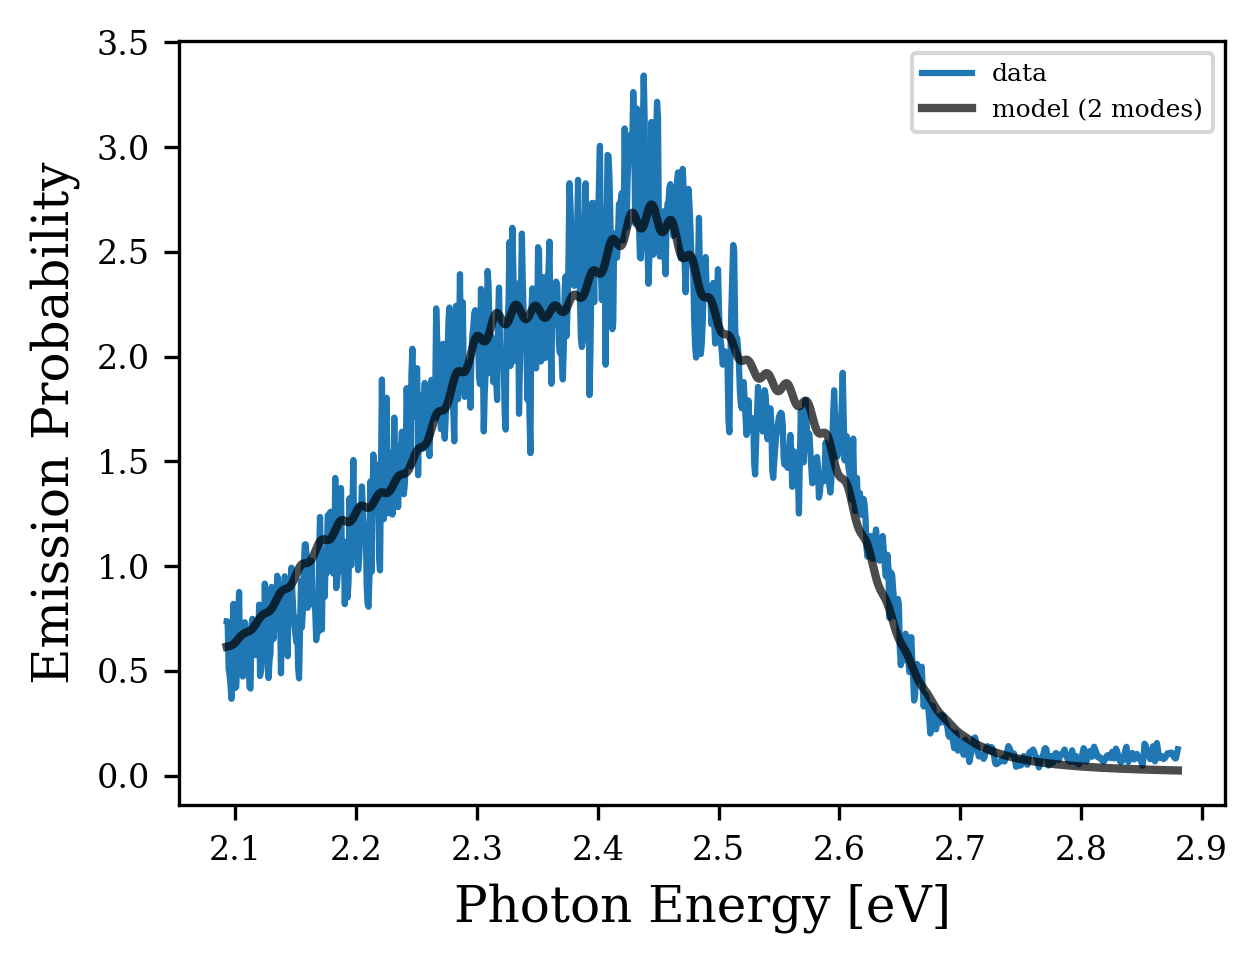

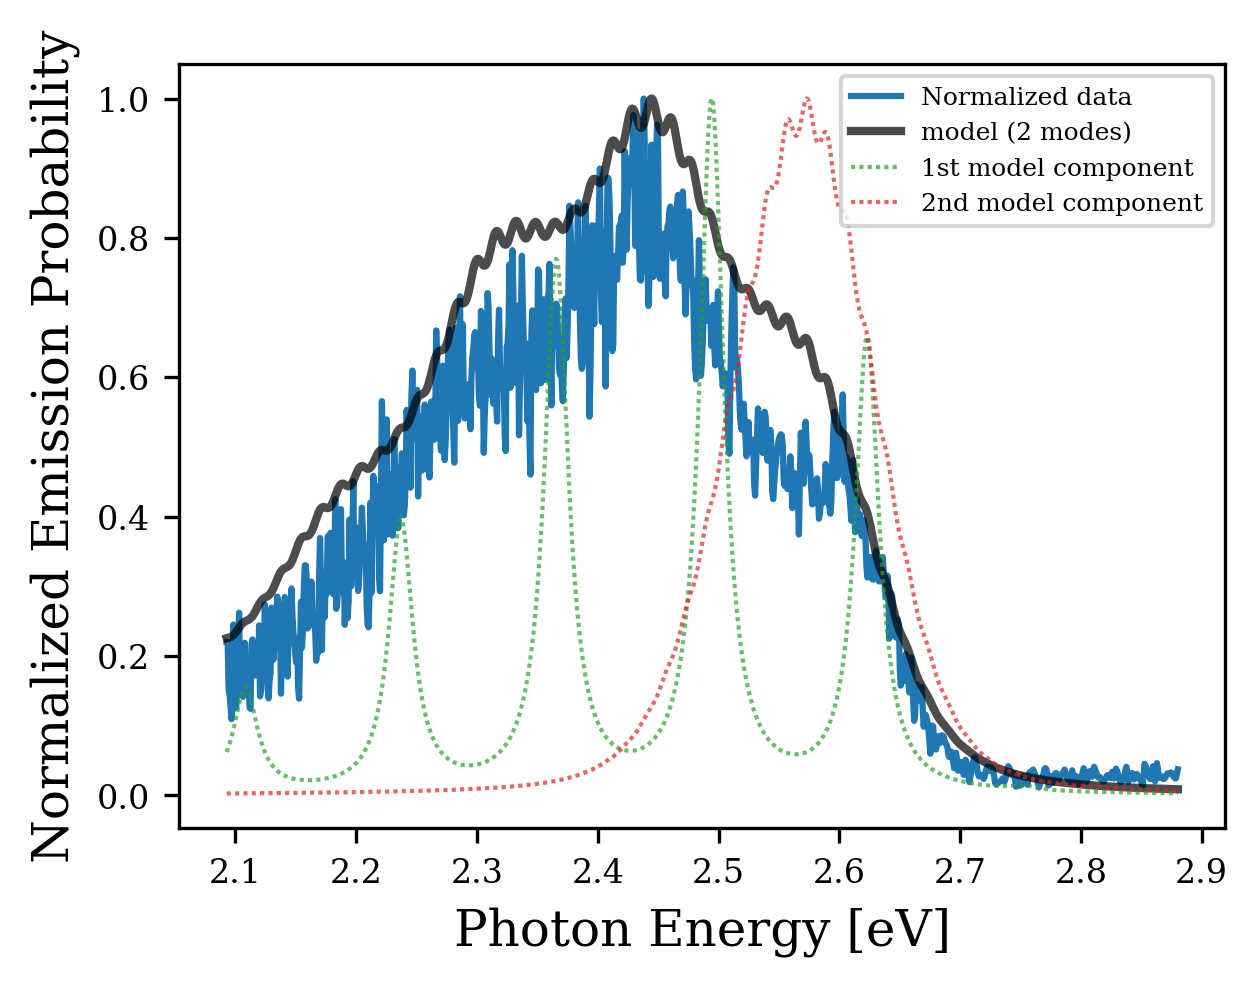

In [100]:
## Build model fit from fit parameters
model_fit_inst = model_from_params(model_fit['x'], num_modes=2, temp=T)

## Get model lineshape
model_2_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 1000)

##
model_1st_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 1000)

model_2nd_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 1000)


## Build first plot
plt.figure()

## Plot data and model fit
plt.plot(emily_data.T[0], (emily_data.T[1]), label='data')
plt.plot(emily_data.T[0], int_norm(model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')

plt.legend(fontsize=6)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Emission Probability')

## second figure with components
plt.figure()
plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]), label='Normalized data')
plt.plot(emily_data.T[0], norm_spec(model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.7, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.7, label='2nd model component')

plt.legend(fontsize=6)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')


In [101]:
def print_parameters_w_names(params):
    """Only works for 2 modes"""
    print(f'hbar_omega_eg_0 = {params[0]}')
    print(f'hbar_gamma = {params[1]}')
    print(f'hbar_omega_0 = {params[2:4]}')
    print(f'script_d = {params[4:6]}')

In [102]:
print_parameters_w_names(model_fit['x'])

hbar_omega_eg_0 = 2.6230779175949093
hbar_gamma = 0.01214648856731883
hbar_omega_0 = [0.12866989 0.01658025]
script_d = [1.74686696 2.55463908]


In [20]:
fit_spectra = np.asarray([ emily_data.T[0], emily_data.T[1], model_2_mode])
np.savetxt("fast_CH3_fit", fit_spectra, delimiter=',')

In [103]:
#residual sum of squares
ss_res= np.sum((emily_data.T[1]- model_2_mode)**2)

#total sum of squares
ss_tot = np.sum((emily_data.T[1]- np.mean(emily_data.T[1]))**2)

#r-squared
r2 = 1- (ss_res/ss_tot)

print(ss_res, r2)

44.08747674803135 0.9470651157886093


In [282]:
def model_from_params(
    params, 
    num_modes, 
    temp
    ):
    return dom.anda_mol_fluo_model(
        num_vib_modes=num_modes,
        hbar_omega_eg_0=float(params[0]),
        script_d=params[2+1*num_modes: 2+2*num_modes],
        hbar_omega_0=params[2: 2+1*num_modes],
        hbar_gamma=[params[1]]*num_modes,
        T=temp)

def muk_mol_fit_fun(params, *args):
    """ Try naive fit function with fixed integration differential size
        and bound.

        Params: (list of fit parameters) Should be list of 
            2 + (3*num_modes) containing the following model parameters;
            ~~~~~~~~~~~~~~~~
            [0] hbar_omega_eg_0: the difference in zero point energy of 
                the vibrational oscillators between the two electronic
                states (eV).
                
            [1] hbar_gamma: damping rate from 
                solvent or etc.
            
            [2:2+num_modes] hbar_omega_0: vibrational ressonance energy 
                in eV.
                
            [2+num_modes:2+2*num_modes] script_d: unitless 
                displacement of the vibronic potential surface between
                electronic states.

        Args: (list of x axis and data)
        ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            hbar_omega:
            data:
            num_modes:
        """
    [
        hbar_omegas, 
        data, 
        num_modes, 
        t_bound, 
        t_points, 
        norm,
        temp
        ] = args

    model_instance = model_from_params(params, num_modes, temp=temp)
    
    model = model_instance.emission_lineshape(
        hbar_omegas/hbar,
        t_bound=t_bound,
        t_points=t_points,
        )

    if (norm is 'integral') or (norm is 'Integral') or (norm is 'int'):
        ## Normalize model and data
        model_area = int.trapz(model, x=hbar_omegas)
        model = model / model_area
    elif norm is 'magnitude':
        ## Normalize model and data
        model = model / np.max(model)
        data = data / np.max(data)

    return (model - data) * (2.15 < hbar_omegas)

In [283]:
## Define initial guesses
ini_hbar_omega_eg_0 = 2.63
ini_script_d = [1.8, 2]
ini_hbar_omega_0 = [0.131, .02]
ini_hbar_gamma = .015
T = 294

## Bounds on fit parameters
bounds_hbar_omega_eg_0 = [2.6, 2.75]
bounds_script_d = [[0, 0], [np.inf, np.inf]]
bounds_hbar_omega_0 = [[0, 0], [np.inf, np.inf]]
bounds_hbar_gamma = [0.001, np.inf]


## New 06/02
## Sort initil guesses into proper order for fit func
fit_ini_guess = np.asarray([
    ini_hbar_omega_eg_0,
    ini_hbar_gamma,
    *ini_hbar_omega_0,
    *ini_script_d,
    ])
## Define arguments for fit routine
## (Might have to change these)

hbar_omegas_arg = emily_data.T[0]
data_arg = emily_data.T[1]
num_modes_arg = 2
t_bound_arg = 1000
t_points_arg = 1000
norm_arg = 'integral'

## Arrange fit arguments
## (Don't change)
fit_args = (
    hbar_omegas_arg,
    data_arg,
    num_modes_arg,
    t_bound_arg,
    t_points_arg,
    norm_arg,
    T
    )

## Build bounds arrays
bounds = np.zeros((2, fit_ini_guess.shape[0]))
bounds[:, 0] = bounds_hbar_omega_eg_0
bounds[:, 1] = bounds_hbar_gamma
bounds[:, 2:2+num_modes_arg] = bounds_hbar_omega_0
bounds[:, 2+num_modes_arg:2+2*num_modes_arg] = bounds_script_d

model_fit = opt.least_squares(
    muk_mol_fit_fun,
    x0=fit_ini_guess,
    args=fit_args,
    bounds=bounds,
    x_scale=[1, .01, .1, .01, 1, 1]
    )

Plot fit result

Text(0, 0.5, 'Normalized Emission Probability')

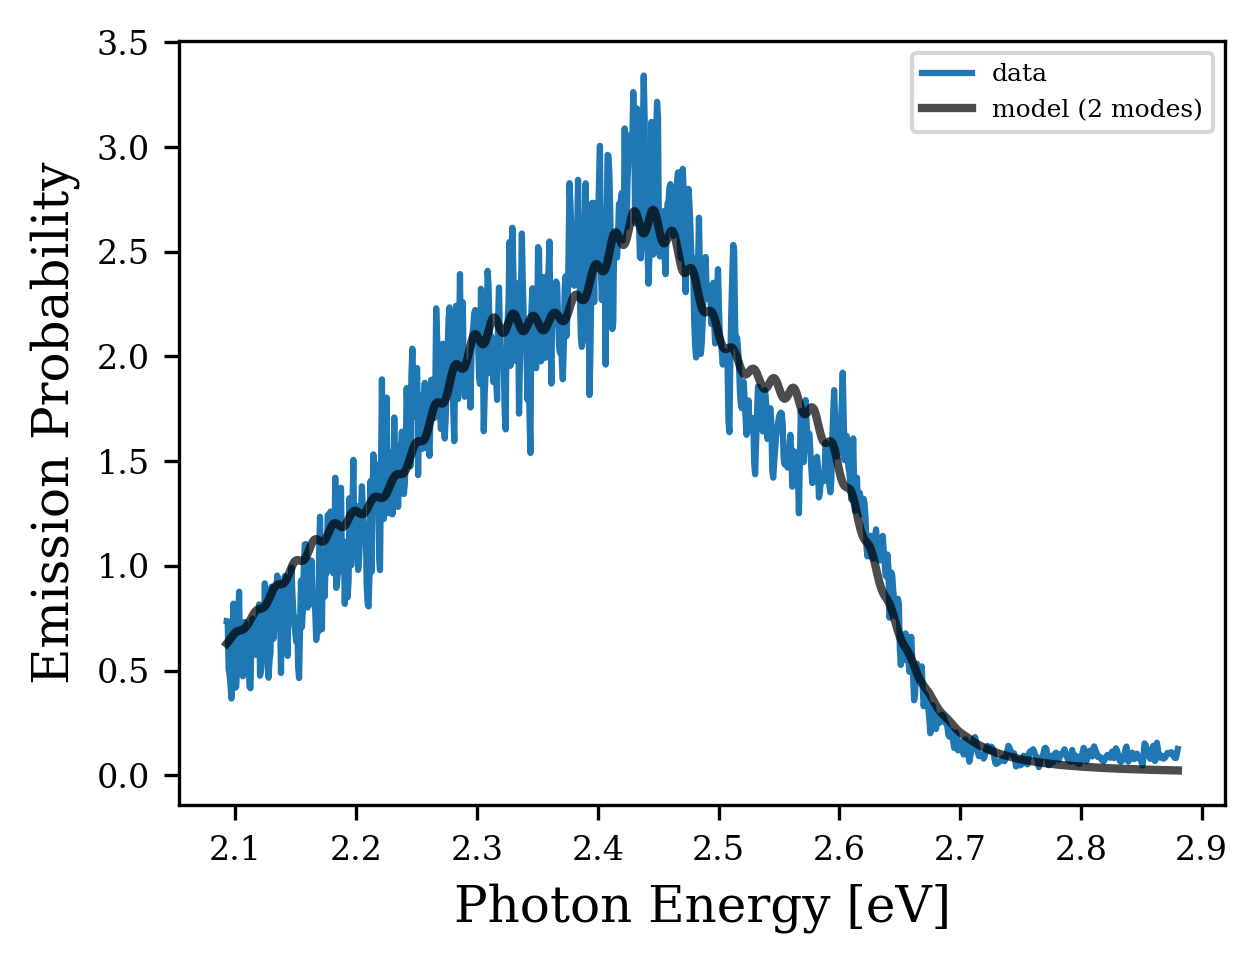

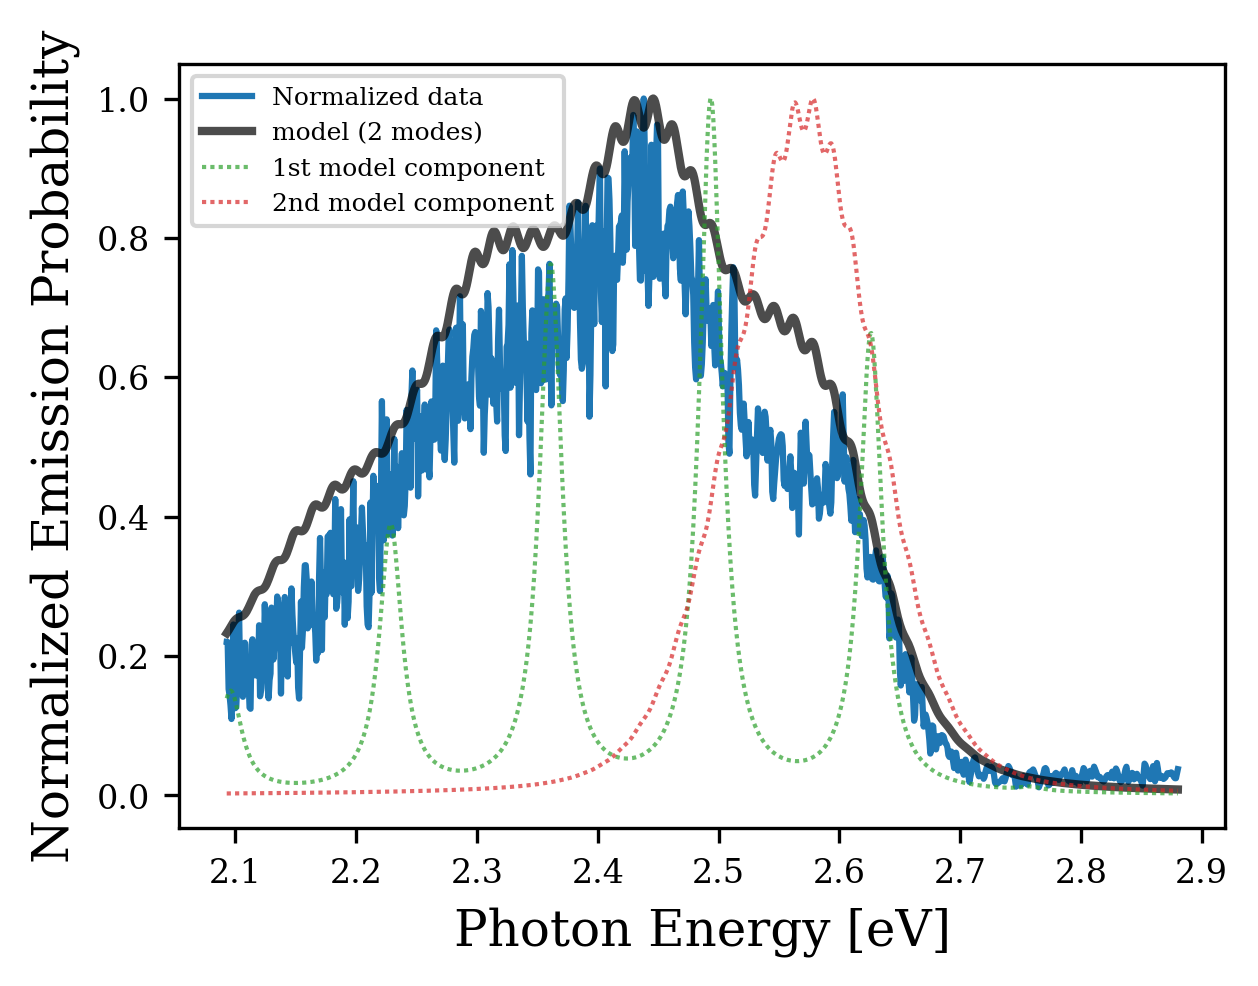

In [284]:
## Build model fit from fit parameters
model_fit_inst = model_from_params(model_fit['x'], num_modes=2, temp=T)

## Get model lineshape
model_2_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 1000)

##
model_1st_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 1000)

model_2nd_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 1000)


## Build first plot
plt.figure()

## Plot data and model fit
plt.plot(emily_data.T[0], (emily_data.T[1]), label='data')
plt.plot(emily_data.T[0], int_norm(model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')

plt.legend(fontsize=6)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Emission Probability')

## second figure with components
plt.figure()
plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]), label='Normalized data')
plt.plot(emily_data.T[0], norm_spec(model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.7, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.7, label='2nd model component')

plt.legend(fontsize=6)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')


In [285]:
def print_parameters_w_names(params):
    """Only works for 2 modes"""
    print(f'hbar_omega_eg_0 = {params[0]}')
    print(f'hbar_gamma = {params[1]}')
    print(f'hbar_omega_0 = {params[2:4]}')
    print(f'script_d = {params[4:6]}')

In [286]:
print_parameters_w_names(model_fit['x'])

hbar_omega_eg_0 = 2.626207079155096
hbar_gamma = 0.011336715720623032
hbar_omega_0 = [0.132529393 0.015875416]
script_d = [1.73952619  2.669827075]


In [168]:
fit_spectra = np.asarray([ emily_data.T[0], emily_data.T[1], model_2_mode])
np.savetxt("fast_CH3_fit", fit_spectra, delimiter=',')

In [287]:
#residual sum of squares
ss_res= np.sum((emily_data.T[1]- model_2_mode)**2)

#total sum of squares
ss_tot = np.sum((emily_data.T[1]- np.mean(emily_data.T[1]))**2)

#r-squared
r2 = 1- (ss_res/ss_tot)

print(ss_res, r2)

46.89682681464661 0.9436919896436167


In [252]:
diag_of_cov = np.diagonal(np.linalg.inv(2 * model_fit.jac.T @ model_fit.jac))

print_parameters_w_names(diag_of_cov)

In [253]:
print_parameters_w_names(diag_of_cov)

hbar_omega_eg_0 = 1.4809555954866855e-05
hbar_gamma = 5.806351232400114e-06
hbar_omega_0 = [5.07494171e-06 4.57371504e-07]
script_d = [0.0007427  0.01315666]


In [289]:
fit_spectra = np.asarray([ emily_data.T[0], emily_data.T[1], model_2_mode, model_1st_mode, model_2nd_mode])
np.savetxt("fast_CH3_fit", fit_spectra, delimiter=',')

# Tighten bounds of fitting

In [259]:
def model_from_params(
    params, 
    num_modes, 
    temp
    ):
    return dom.anda_mol_fluo_model(
        num_vib_modes=num_modes,
        hbar_omega_eg_0=float(params[0]),
        script_d=params[2+1*num_modes: 2+2*num_modes],
        hbar_omega_0=params[2: 2+1*num_modes],
        hbar_gamma=[params[1]]*num_modes,
        T=temp)

def muk_mol_fit_fun(params, *args):
    """ Try naive fit function with fixed integration differential size
        and bound.

        Params: (list of fit parameters) Should be list of 
            2 + (3*num_modes) containing the following model parameters;
            ~~~~~~~~~~~~~~~~
            [0] hbar_omega_eg_0: the difference in zero point energy of 
                the vibrational oscillators between the two electronic
                states (eV).
                
            [1] hbar_gamma: damping rate from 
                solvent or etc.
            
            [2:2+num_modes] hbar_omega_0: vibrational ressonance energy 
                in eV.
                
            [2+num_modes:2+2*num_modes] script_d: unitless 
                displacement of the vibronic potential surface between
                electronic states.

        Args: (list of x axis and data)
        ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            hbar_omega:
            data:
            num_modes:
        """
    [
        hbar_omegas, 
        data, 
        num_modes, 
        t_bound, 
        t_points, 
        norm,
        temp
        ] = args

    model_instance = model_from_params(params, num_modes, temp=temp)
    
    model = model_instance.emission_lineshape(
        hbar_omegas/hbar,
        t_bound=t_bound,
        t_points=t_points,
        )

    if (norm is 'integral') or (norm is 'Integral') or (norm is 'int'):
        ## Normalize model and data
        model_area = int.trapz(model, x=hbar_omegas)
        model = model / model_area
    elif norm is 'magnitude':
        ## Normalize model and data
        model = model / np.max(model)
        data = data / np.max(data)

    return (model - data) * (np.logical_and(2.15 < hbar_omegas, hbar_omegas < 2.75))

In [263]:

## Define initial guesses
ini_hbar_omega_eg_0 = 2.63
ini_script_d = [1.8, 2]
ini_hbar_omega_0 = [0.131, .02]
ini_hbar_gamma = .015
T = 294

## Bounds on fit parameters
bounds_hbar_omega_eg_0 = [2.6, 2.75]
bounds_script_d = [[0, 0], [np.inf, np.inf]]
bounds_hbar_omega_0 = [[0, 0], [np.inf, np.inf]]
bounds_hbar_gamma = [0.001, np.inf]


## New 06/02
## Sort initil guesses into proper order for fit func
fit_ini_guess = np.asarray([
    ini_hbar_omega_eg_0,
    ini_hbar_gamma,
    *ini_hbar_omega_0,
    *ini_script_d,
    ])
## Define arguments for fit routine
## (Might have to change these)

hbar_omegas_arg = emily_data.T[0]
data_arg = emily_data.T[1]
num_modes_arg = 2
t_bound_arg = 1000
t_points_arg = 1000
norm_arg = 'integral'

## Arrange fit arguments
## (Don't change)
fit_args = (
    hbar_omegas_arg,
    data_arg,
    num_modes_arg,
    t_bound_arg,
    t_points_arg,
    norm_arg,
    T
    )

## Build bounds arrays
bounds = np.zeros((2, fit_ini_guess.shape[0]))
bounds[:, 0] = bounds_hbar_omega_eg_0
bounds[:, 1] = bounds_hbar_gamma
bounds[:, 2:2+num_modes_arg] = bounds_hbar_omega_0
bounds[:, 2+num_modes_arg:2+2*num_modes_arg] = bounds_script_d

model_fit = opt.least_squares(
    muk_mol_fit_fun,
    x0=fit_ini_guess,
    args=fit_args,
    bounds=bounds,
    x_scale=[1, .01, .1, .01, 1, 1]
    )

Plot fit result

Text(0, 0.5, 'Normalized Emission Probability')

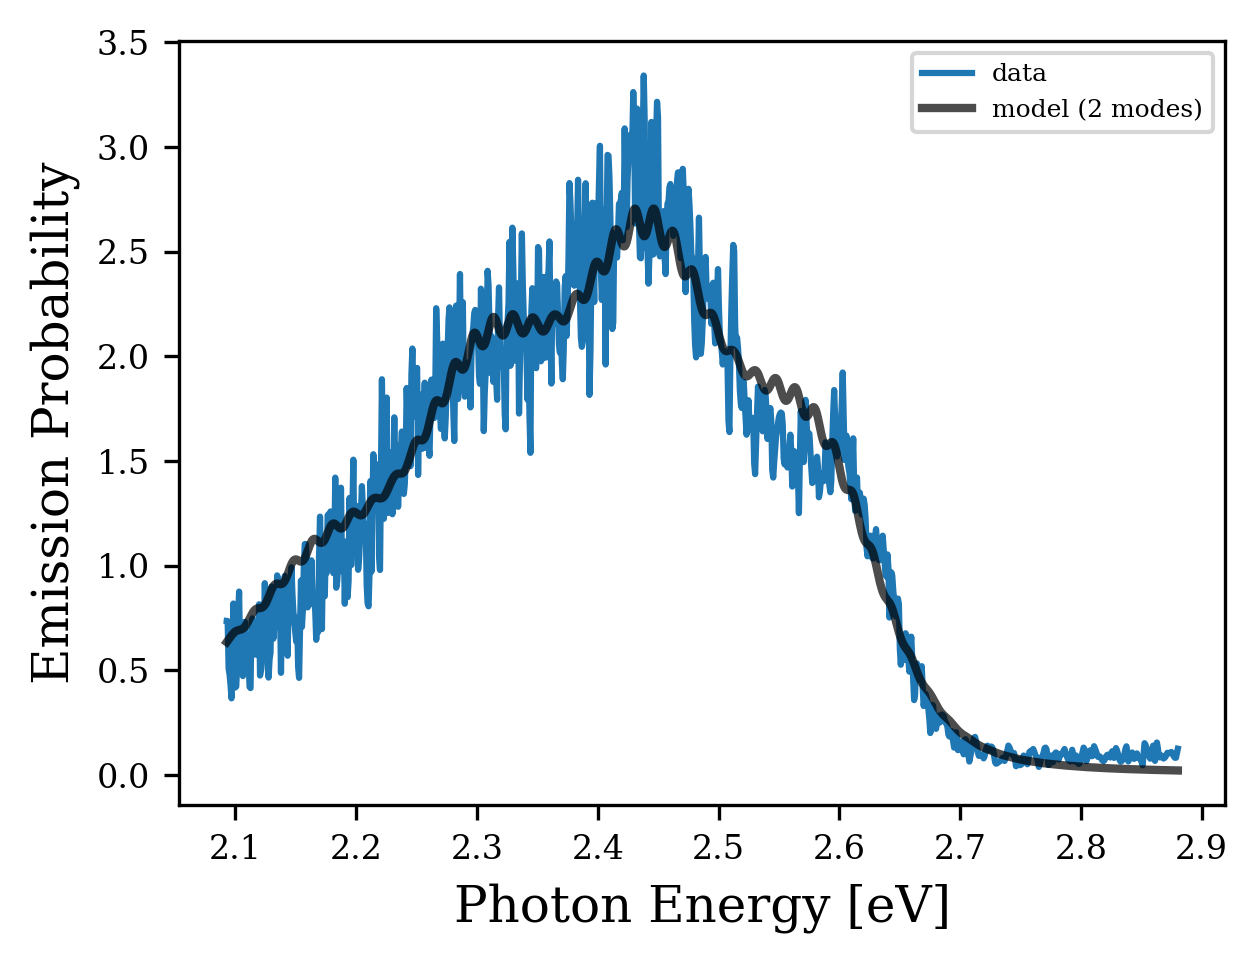

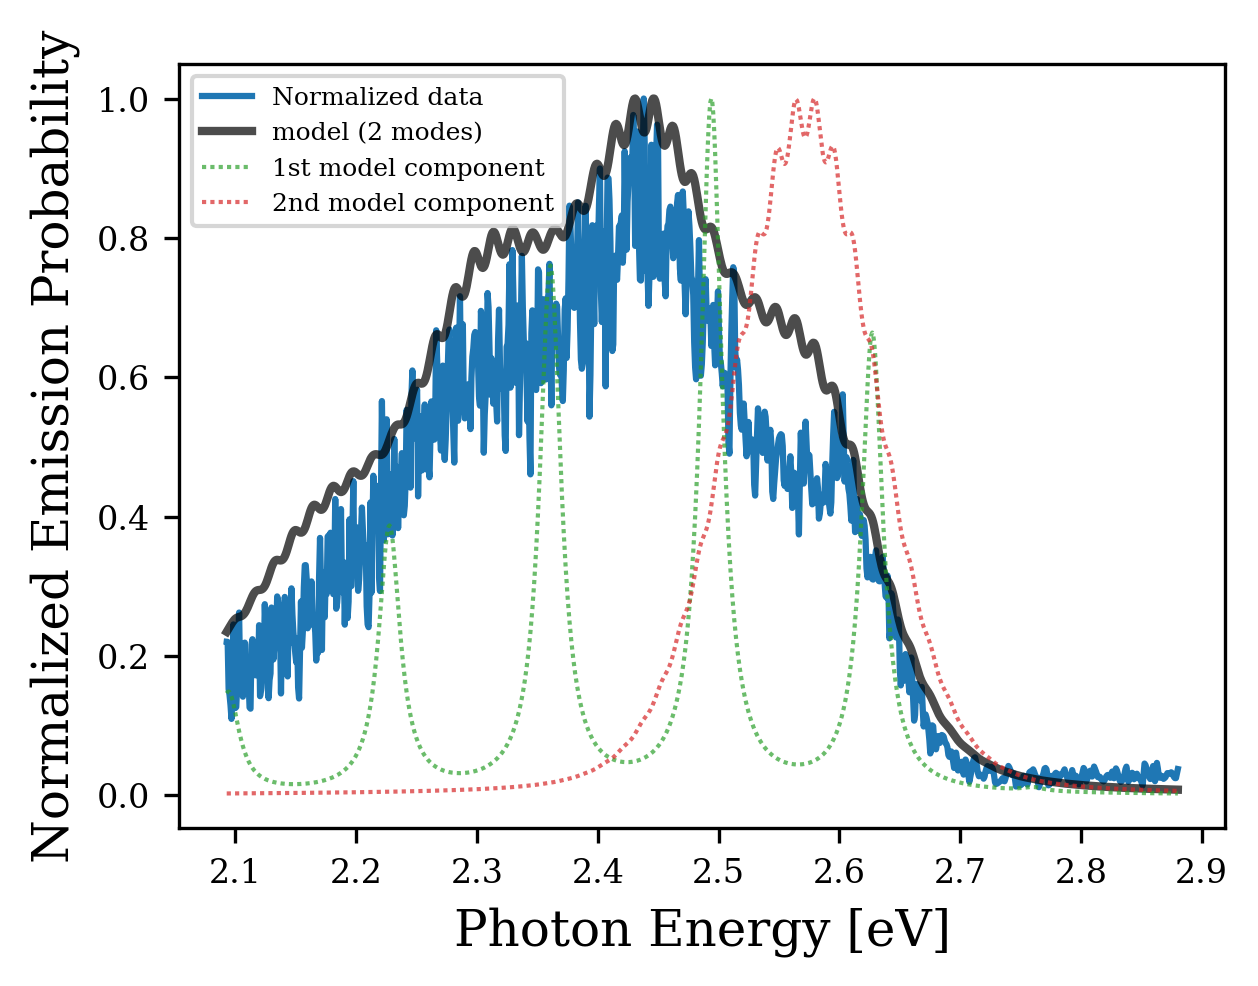

In [264]:
## Build model fit from fit parameters
model_fit_inst = model_from_params(model_fit['x'], num_modes=2, temp=T)

## Get model lineshape
model_2_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 1000)

##
model_1st_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 1000)

model_2nd_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 1000)


## Build first plot
plt.figure()

## Plot data and model fit
plt.plot(emily_data.T[0], (emily_data.T[1]), label='data')
plt.plot(emily_data.T[0], int_norm(model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')

plt.legend(fontsize=6)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Emission Probability')

## second figure with components
plt.figure()
plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]), label='Normalized data')
plt.plot(emily_data.T[0], norm_spec(model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.7, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.7, label='2nd model component')

plt.legend(fontsize=6)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')


In [265]:
print_parameters_w_names(model_fit['x'])

hbar_omega_eg_0 = 2.627298695812648
hbar_gamma = 0.010793154769921754
hbar_omega_0 = [0.13 0.02]
script_d = [1.74 2.69]


In [266]:
#residual sum of squares
ss_res= np.sum((emily_data.T[1]- model_2_mode)**2)

#total sum of squares
ss_tot = np.sum((emily_data.T[1]- np.mean(emily_data.T[1]))**2)

#r-squared
r2 = 1- (ss_res/ss_tot)

print(ss_res, r2)

47.177385155023885 0.9433551292842159


In [252]:
diag_of_cov = np.diagonal(np.linalg.inv(2 * model_fit.jac.T @ model_fit.jac))

In [253]:
print_parameters_w_names(diag_of_cov)

hbar_omega_eg_0 = 1.4809555954866855e-05
hbar_gamma = 5.806351232400114e-06
hbar_omega_0 = [5.07494171e-06 4.57371504e-07]
script_d = [0.0007427  0.01315666]


In [279]:
np.set_printoptions(precision=9)
print('Covarience Matrix')
print(np.linalg.inv(2 * model_fit.jac.T @ model_fit.jac))

Covarience Matrix
[[ 1.791219129e-05 -1.264329662e-06  6.412225329e-06  1.732441519e-06
  -1.036884692e-05  1.666736694e-04]
 [-1.264329662e-06  7.380329867e-06 -2.515821750e-06  9.387438167e-07
   8.892592307e-06 -1.357203531e-04]
 [ 6.412225329e-06 -2.515821750e-06  6.346798666e-06 -2.335905997e-07
  -2.253833184e-05  1.540062937e-04]
 [ 1.732441519e-06  9.387438167e-07 -2.335905997e-07  7.376411413e-07
   1.907465806e-06 -3.424360923e-05]
 [-1.036884692e-05  8.892592307e-06 -2.253833184e-05  1.907465806e-06
   7.721599512e-04 -2.253169960e-03]
 [ 1.666736694e-04 -1.357203531e-04  1.540062937e-04 -3.424360923e-05
  -2.253169960e-03  1.547016585e-02]]


In [ ]:
# plt.fill_between()